In [1]:
import matplotlib.pyplot as plt
import pickle
import numpy as np
import matplotlib.patches as mpatches

import sys
# caution: path[0] is reserved for script path (or '' in REPL)
sys.path.insert(1, 'code')
from help_funcs import *

import matplotlib
import scipy.io

matplotlib.rcParams.update({'font.size': 18})

pvcolor = (0.0, 0.4039, 0.7059)
sstcolor = (0.898,0.6314,0.0039)
REVISION_DATA_DIR ='revision_data'

## Response Fig 4A

In [11]:
# Get Position Data and save as mat file
simname = 't90_a0.07_pf0.8'

stim = 'PV'
cont = 0.18
seed = 1
cond = 'PV_0.18'
datadir='/storage/home/hcoda1/5/skim3438/p-hchoi387-0/CellTypeCircuit/newCode/data'

# with open(f'{datadir}/{simname}/results_{seed}/%s_spikes.pickle'%cond,'rb') as f:
#     all_spikes = pickle.load(f)
with open(f'{datadir}/{simname}/results_{seed}/%s_positions.pickle'%cond,'rb') as f:
    all_positions = pickle.load(f)
# plot_raster(all_spikes, all_positions, tmin = 800, tmax = 1200)

data = {'E_positions': all_positions[:8000],
       'PV_positions': all_positions[8000:9000],
       'SST_positions': all_positions[9000:]}
scipy.io.savemat(f'{REVISION_DATA_DIR}/RespFig4A.mat', data)

In [2]:
#Retrieve data from mat file
data = scipy.io.loadmat(f'{REVISION_DATA_DIR}/RespFig4A.mat')
e_pos, p_pos, s_pos = data['E_positions'], data['PV_positions'],data['SST_positions']
all_positions = np.concatenate([e_pos,p_pos,s_pos], axis=0)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


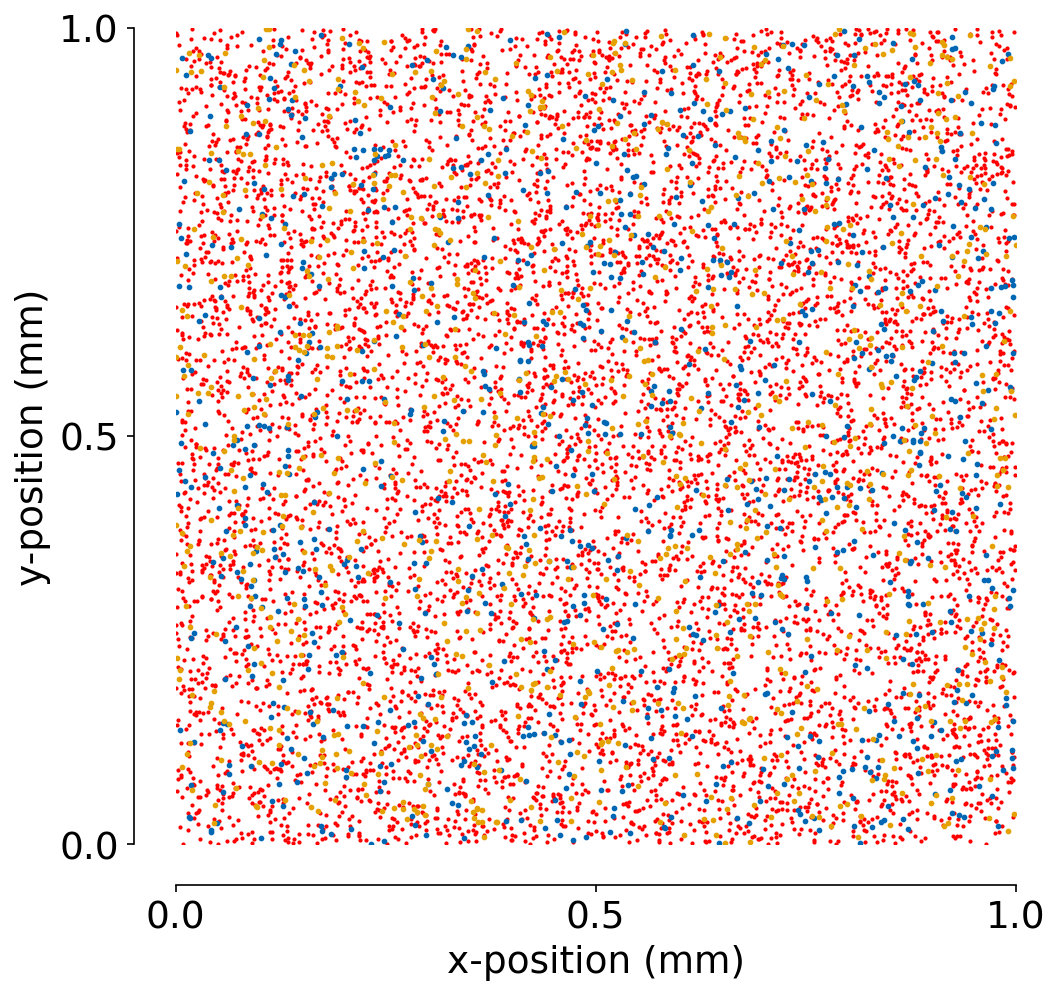

In [3]:
fig, ax = plt.subplots(figsize=(8,8), dpi=150)
ax.scatter(all_positions[:8000,0], all_positions[:8000,1], c='red', s=1)
ax.scatter(all_positions[8000:9000,0], all_positions[8000:9000,1], c=pvcolor, s=3)
ax.scatter(all_positions[9000:,0], all_positions[9000:,1], c=sstcolor, s=3)

ax.set_xticks([])
ax.set_yticks([])

plt.gca().spines['left'].set_position(('data', -0.05))
plt.gca().spines['bottom'].set_position(('data', -0.05))

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.xticks([0, 0.5, 1])
plt.yticks([0, 0.5, 1])

ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.set_xlabel('x-position (mm)')
ax.set_ylabel('y-position (mm)')

plt.subplots_adjust(left=0.2,bottom=0.2)

plt.savefig('response_figs/RespFig4a.svg')
# plt.show()

## Response Fig 3B

In [32]:
def get_rates(all_spikes, all_positions, t_starts=[300, 1900, 3500], binsize=100):
    D=20
    exc_count = np.zeros((D, D), dtype=int)
    pv_count = np.zeros((D, D), dtype=int)
    sst_count = np.zeros((D, D), dtype=int)
    total_time = 0
    for t_start in t_starts:
        print(t_start, end=' ')
        t_stop = t_start + binsize
        total_time += binsize
        # Initialize empty lists to store positions of spiking neurons
        exc_positions = []
        pv_positions = []
        sst_positions = []

        # Iterate over neurons and their spike times
        for i, spikes in enumerate(all_spikes):
            # Check if the neuron spiked between t_start and t_stop
            spiking_times = spikes[(spikes >= t_start) & (spikes <= t_stop)]
            if len(spiking_times) > 0:
                # Append positions based on neuron type
                if i < 8000:
                    exc_positions.extend(all_positions[i, :].tolist() for _ in spiking_times)
                elif 8000 <= i < 9000:
                    pv_positions.extend(all_positions[i, :].tolist() for _ in spiking_times)
                else:
                    sst_positions.extend(all_positions[i, :].tolist() for _ in spiking_times)

        # Convert lists to numpy arrays for plotting
        exc_positions = np.array(exc_positions)
        pv_positions = np.array(pv_positions)
        sst_positions = np.array(sst_positions)

        # Iterate over each particle and count the number of particles in each patch
        for particle in exc_positions:
            x_index = int(particle[0] * D)  # Determine the x index
            y_index = int(particle[1] * D)  # Determine the y index
            exc_count[x_index, y_index] += 1  # Increment the count for the corresponding patch
        # Iterate over each particle and count the number of particles in each patch
        for particle in pv_positions:
            x_index = int(particle[0] * D)  # Determine the x index
            y_index = int(particle[1] * D)  # Determine the y index
            pv_count[x_index, y_index] += 1  # Increment the count for the corresponding patch
        # Iterate over each particle and count the number of particles in each patch
        for particle in sst_positions:
            x_index = int(particle[0] * D)  # Determine the x index
            y_index = int(particle[1] * D)  # Determine the y index
            sst_count[x_index, y_index] += 1  # Increment the count for the corresponding patch

    total_time = total_time/1000
    nexc = 8000/(D**2)
    ninh = 1000/(D**2)
    return exc_count/total_time/nexc, pv_count/total_time/ninh, sst_count/total_time/ninh

In [48]:
simname = 't90_a0.07_pf0.8'
cond = 'PV_0.33'
stim_times = [1100+1600*i for i in range(3)]
control_times = [300+1600*i for i in range(3)]

exc_all_rates_control, pv_all_rates_control, sst_all_rates_control = [], [], []
exc_all_rates_pv, pv_all_rates_pv, sst_all_rates_pv = [], [], []
exc_all_rates_sst, pv_all_rates_sst, sst_all_rates_sst = [], [], []

for seed in range(1,101):
    print(seed, end= ',')
    datadir='/storage/home/hcoda1/5/skim3438/p-hchoi387-0/CellTypeCircuit/newCode/data'
    with open(f'{datadir}/{simname}/results_{seed}/%s_spikes.pickle'%cond,'rb') as f:
        all_spikes = pickle.load(f)
    with open(f'{datadir}/{simname}/results_{seed}/%s_positions.pickle'%cond,'rb') as f:
        all_positions = pickle.load(f)
        
    exc_rate, pv_rate, sst_rate = get_rates(all_spikes, all_positions, t_starts = control_times)
    
    exc_all_rates_control.append(exc_rate)
    pv_all_rates_control.append(pv_rate)
    sst_all_rates_control.append(sst_rate)
    
    exc_rate, pv_rate, sst_rate = get_rates(all_spikes, all_positions, t_starts = stim_times)
    
    exc_all_rates_pv.append(exc_rate)
    pv_all_rates_pv.append(pv_rate)
    sst_all_rates_pv.append(sst_rate)
    
cond = 'SOM_0.33'
for seed in range(1,101):
    print(seed, end= ',')
    datadir='/storage/home/hcoda1/5/skim3438/p-hchoi387-0/CellTypeCircuit/newCode/data'
    with open(f'{datadir}/{simname}/results_{seed}/%s_spikes.pickle'%cond,'rb') as f:
        all_spikes = pickle.load(f)
    with open(f'{datadir}/{simname}/results_{seed}/%s_positions.pickle'%cond,'rb') as f:
        all_positions = pickle.load(f)
    
    exc_rate, pv_rate, sst_rate = get_rates(all_spikes, all_positions, t_starts = stim_times)
    
    exc_all_rates_sst.append(exc_rate)
    pv_all_rates_sst.append(pv_rate)
    sst_all_rates_sst.append(sst_rate)

1,300 1900 3500 1100 2700 4300 2,300 1900 3500 1100 2700 4300 3,300 1900 3500 1100 2700 4300 4,300 1900 3500 1100 2700 4300 5,300 1900 3500 1100 2700 4300 6,300 1900 3500 1100 2700 4300 7,300 1900 3500 1100 2700 4300 8,300 1900 3500 1100 2700 4300 9,300 1900 3500 1100 2700 4300 10,300 1900 3500 1100 2700 4300 11,300 1900 3500 1100 2700 4300 12,300 1900 3500 1100 2700 4300 13,300 1900 3500 1100 2700 4300 14,300 1900 3500 1100 2700 4300 15,300 1900 3500 1100 2700 4300 16,300 1900 3500 1100 2700 4300 17,300 1900 3500 1100 2700 4300 18,300 1900 3500 1100 2700 4300 19,300 1900 3500 1100 2700 4300 20,300 1900 3500 1100 2700 4300 21,300 1900 3500 1100 2700 4300 22,300 1900 3500 1100 2700 4300 23,300 1900 3500 1100 2700 4300 24,300 1900 3500 1100 2700 4300 25,300 1900 3500 1100 2700 4300 26,300 1900 3500 1100 2700 4300 27,300 1900 3500 1100 2700 4300 28,300 1900 3500 1100 2700 4300 29,300 1900 3500 1100 2700 4300 30,300 1900 3500 1100 2700 4300 31,300 1900 3500 1100 2700 4300 32,300 1900 3500 

In [49]:
exc_all_rates = np.array(exc_all_rates_control)
pv_all_rates = np.array(pv_all_rates_control)
sst_all_rates = np.array(sst_all_rates_control)
exc_rates_control = np.mean(exc_all_rates, axis=0)
pv_rates_control = np.mean(pv_all_rates, axis=0)
sst_rates_control = np.mean(sst_all_rates, axis=0)

exc_all_rates = np.array(exc_all_rates_pv)
pv_all_rates = np.array(pv_all_rates_pv)
sst_all_rates = np.array(sst_all_rates_pv)
exc_rates_pv = np.mean(exc_all_rates, axis=0)
pv_rates_pv = np.mean(pv_all_rates, axis=0)
sst_rates_pv = np.mean(sst_all_rates, axis=0)

exc_all_rates = np.array(exc_all_rates_sst)
pv_all_rates = np.array(pv_all_rates_sst)
sst_all_rates = np.array(sst_all_rates_sst)
exc_rates_sst = np.mean(exc_all_rates, axis=0)
pv_rates_sst = np.mean(pv_all_rates, axis=0)
sst_rates_sst = np.mean(sst_all_rates, axis=0)

In [52]:
from scipy.ndimage import gaussian_filter

smooth = True

if smooth == True:
    exc_smoothed_control = gaussian_filter(exc_rates_control, sigma=2)
    pv_smoothed_control = gaussian_filter(pv_rates_control, sigma=2)
    sst_smoothed_control = gaussian_filter(sst_rates_control, sigma=2)

    exc_smoothed_pv = gaussian_filter(exc_rates_pv, sigma=2)
    pv_smoothed_pv = gaussian_filter(pv_rates_pv, sigma=2)
    sst_smoothed_pv = gaussian_filter(sst_rates_pv, sigma=2)

    exc_smoothed_sst = gaussian_filter(exc_rates_sst, sigma=2)
    pv_smoothed_sst = gaussian_filter(pv_rates_sst, sigma=2)
    sst_smoothed_sst = gaussian_filter(sst_rates_sst, sigma=2)

    exc_smoothed_all = [exc_smoothed_control, exc_smoothed_pv, exc_smoothed_sst]
    pv_smoothed_all  = [pv_smoothed_control,  pv_smoothed_pv,  pv_smoothed_sst]
    sst_smoothed_all = [sst_smoothed_control, sst_smoothed_pv, sst_smoothed_sst]

else:
    exc_smoothed_all = [exc_rates_control, exc_rates_pv, exc_rates_sst]
    pv_smoothed_all  = [pv_rates_control,  pv_rates_pv,  pv_rates_sst]
    sst_smoothed_all = [sst_rates_control, sst_rates_pv, sst_rates_sst]

In [145]:
data = {'E_Rate_Control': exc_smoothed_control, 'E_Rate_PVStim': exc_smoothed_pv, 'E_Rate_SSTStim': exc_smoothed_sst,
       'PV_Rate_Control': pv_smoothed_control,  'PV_Rate_PVStim': pv_smoothed_pv, 'PV_Rate_SSTStim': pv_smoothed_sst,
       'SST_Rate_Control': sst_smoothed_control, 'SST_Rate_PVStim': sst_smoothed_pv, 'SST_Rate_SSTStim': sst_smoothed_sst}

scipy.io.savemat(f'{REVISION_DATA_DIR}/RespFig4B.mat',data)

In [29]:
## Load saved data
data = scipy.io.loadmat(f'{REVISION_DATA_DIR}/RespFig4B.mat')
exc_smoothed_all = [data['E_Rate_Control'],   data['E_Rate_PVStim'],   data['E_Rate_SSTStim']]
pv_smoothed_all  = [data['PV_Rate_Control'],  data['PV_Rate_PVStim'],  data['PV_Rate_SSTStim']]
sst_smoothed_all = [data['SST_Rate_Control'], data['SST_Rate_PVStim'], data['SST_Rate_SSTStim']]

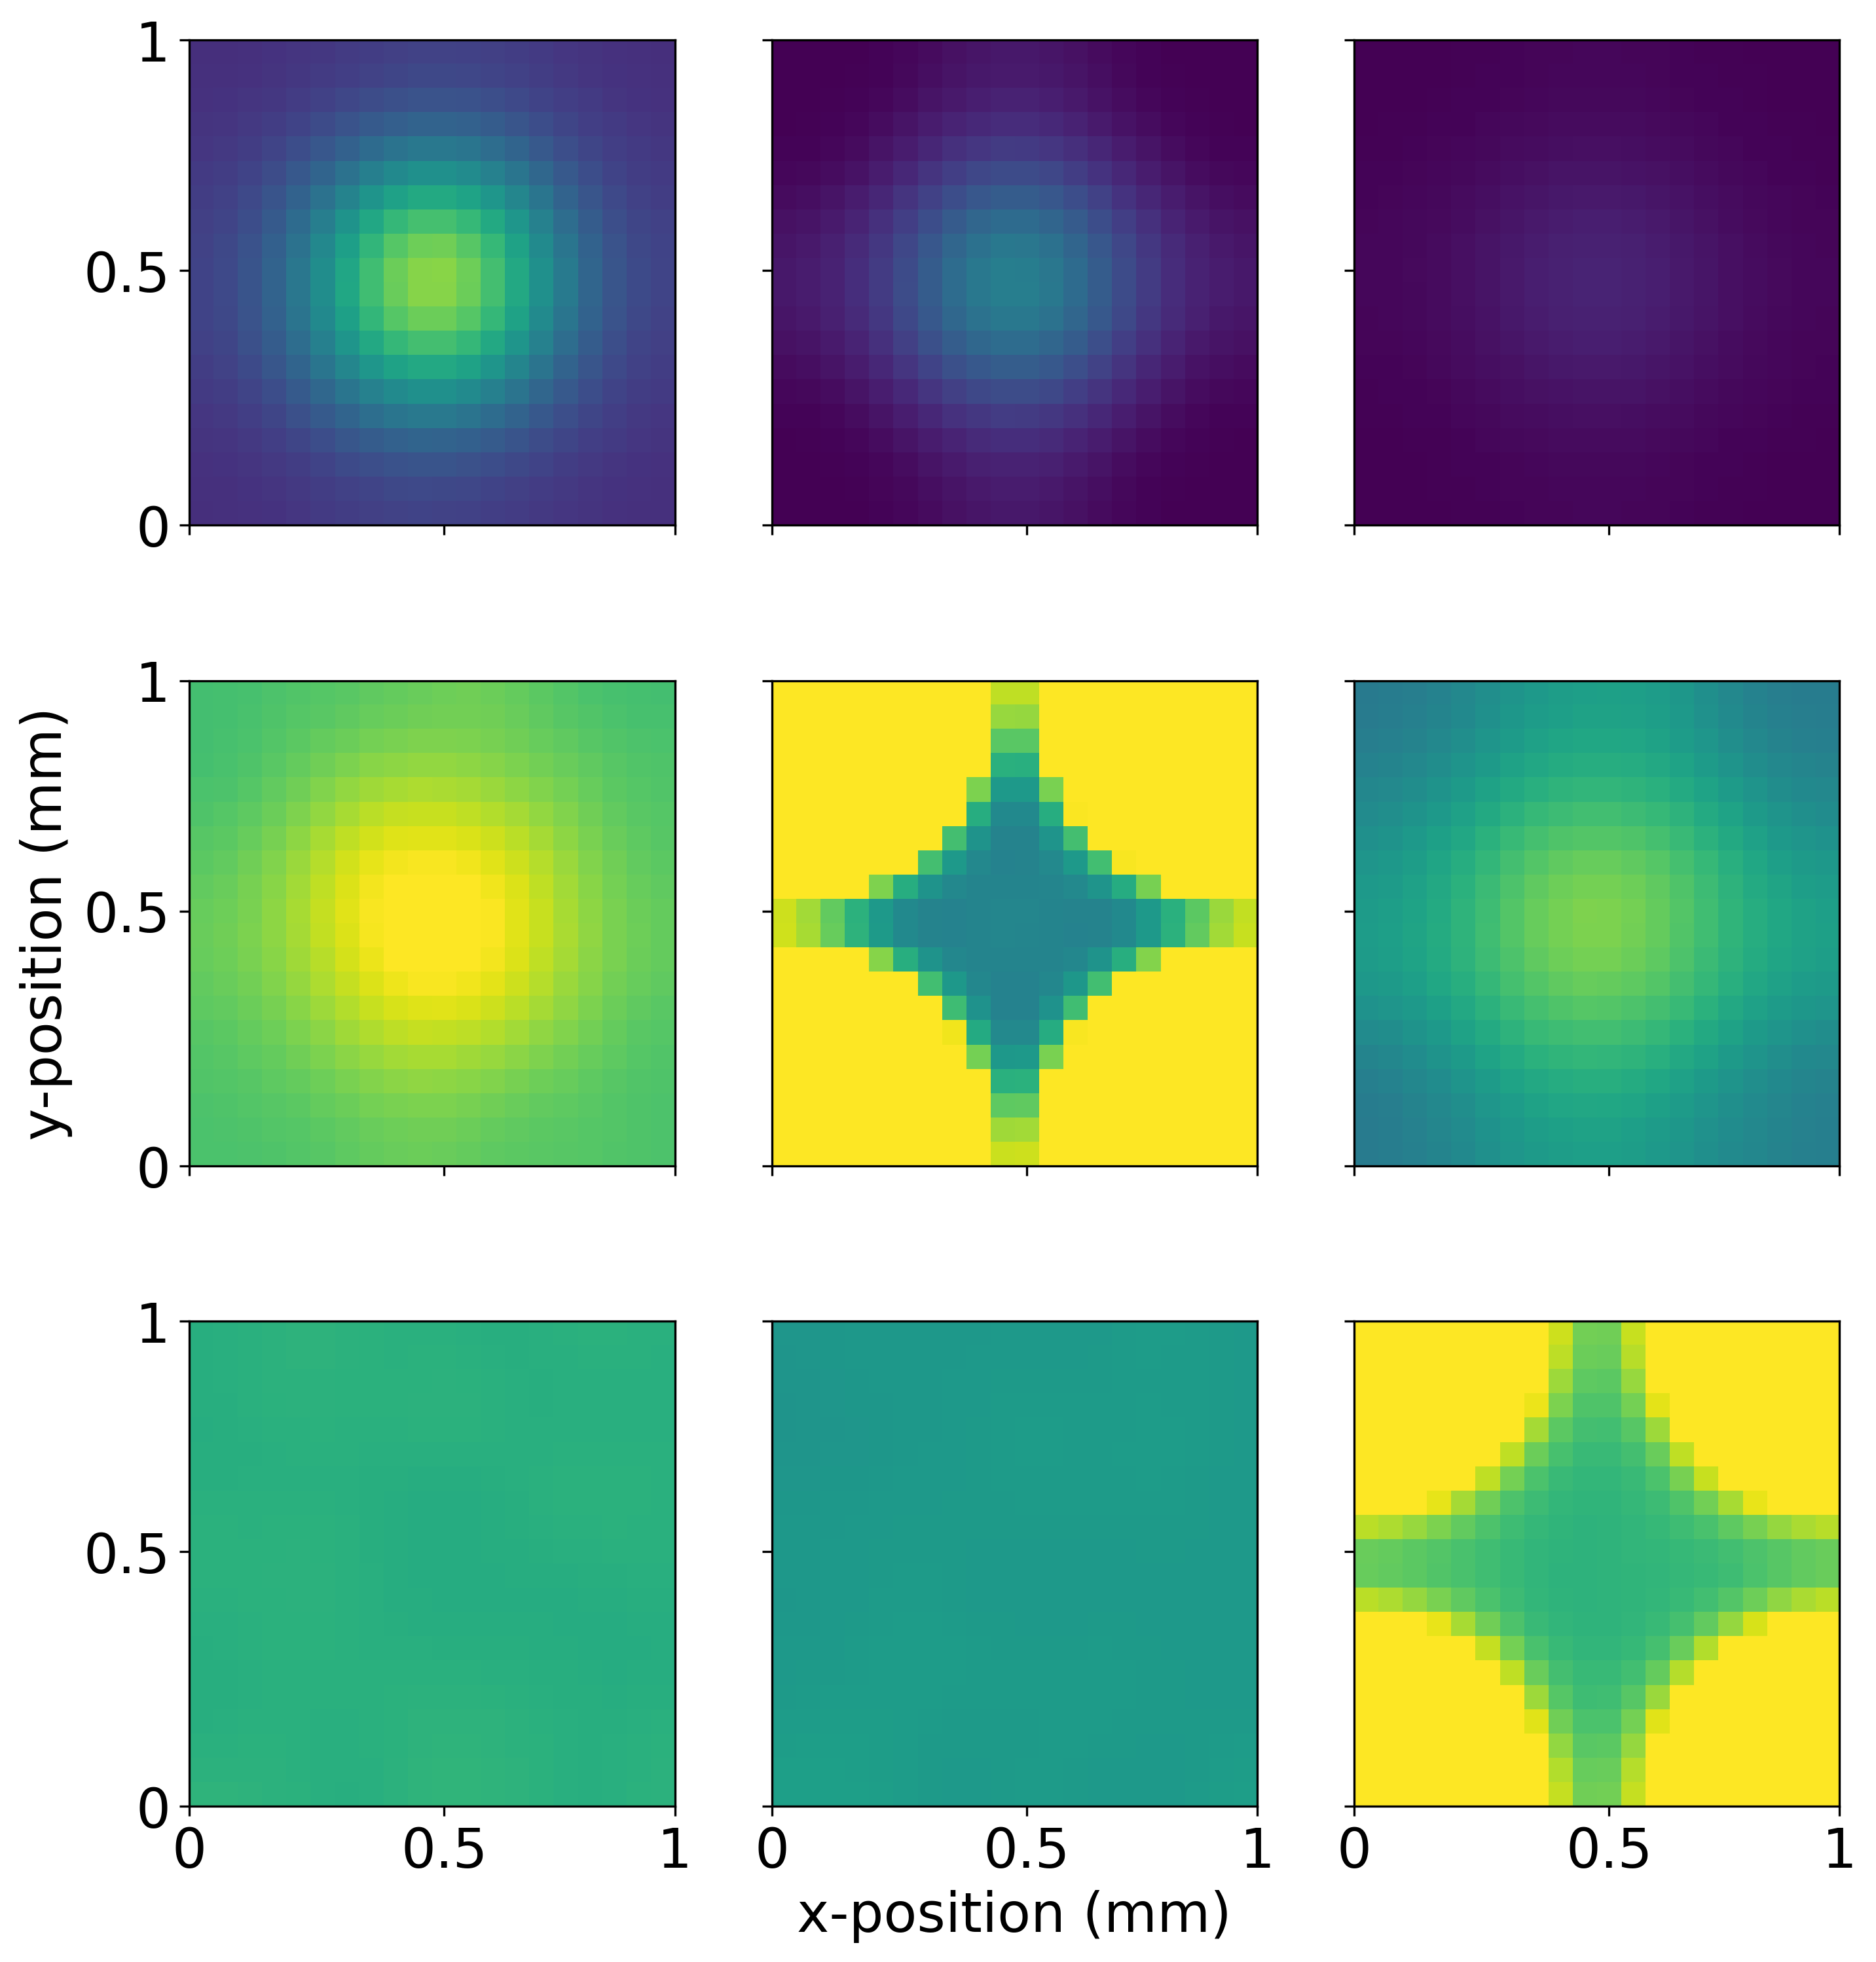

In [36]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

matplotlib.rcParams.update({'font.size': 20})
fig, axes = plt.subplots(3,3,figsize=(12,12), dpi=300)
vm = 6
for cond_i in range(3):
    ax = axes[0, cond_i]

    exc_smoothed = exc_smoothed_all[cond_i]
    im = ax.imshow(exc_smoothed, vmin=0, vmax = vm)
    ax.set_xlim(-0.5,19.5)
    ax.set_ylim(-0.5,19.5)
    ax.set_xticks([-0.5,10,19.5])
    ax.set_yticks([-0.5,10,19.5])
    ax.set_xticklabels(['','',''])
    ax.set_yticklabels(['','',''])
    # ax.set_yticklabels([0,0.5,1])
    # ax.set_ylabel('Exc')
    if cond_i==0:
        ax.set_yticklabels([0,0.5,1])


#     divider = make_axes_locatable(ax)
#     cax = divider.append_axes('right', size='5%', pad=0.2)
#     fig.colorbar(im, cax=cax, orientation='vertical')

    ax = axes[1, cond_i]

    pv_smoothed = pv_smoothed_all[cond_i]
    im = ax.imshow(pv_smoothed, vmin=0, vmax = vm)
    ax.set_xlim(-0.5,19.5)
    ax.set_ylim(-0.5,19.5)
    ax.set_xticks([-0.5,10,19.5])
    ax.set_yticks([-0.5,10,19.5])
    ax.set_xticklabels(['','',''])
    ax.set_yticklabels(['','',''])
    # ax.set_yticklabels([0,0.5,1])
    # ax.set_ylabel('PV')
    if cond_i==0:
        ax.set_yticklabels([0,0.5,1])
        ax.set_ylabel('y-position (mm)')

#     divider = make_axes_locatable(ax)
#     cax = divider.append_axes('right', size='5%', pad=0.2)
#     fig.colorbar(im, cax=cax, orientation='vertical')

    ax = axes[2, cond_i]
#     im = ax.imshow(sst_rates, vmin=0)#, vmax= vm)
    sst_smoothed = sst_smoothed_all[cond_i]
    im = ax.imshow(sst_smoothed, vmin=0, vmax = vm)
    ax.set_xlim(-0.5,19.5)
    ax.set_ylim(-0.5,19.5)
    ax.set_xticks([-0.5,10,19.5])
    ax.set_yticks([-0.5,10,19.5])
    ax.set_xticklabels(['','',''])
    ax.set_yticklabels(['','',''])
    ax.set_xticklabels([0,0.5,1])
    # ax.set_yticklabels([0,0.5,1])
    # ax.set_ylabel('SST')
    
    if cond_i==0:
        ax.set_yticklabels([0,0.5,1])
    if cond_i ==1:
        ax.set_xlabel('x-position (mm)')

#     divider = make_axes_locatable(ax)
#     cax = divider.append_axes('right', size='5%', pad=0.2)
#     fig.colorbar(im, cax=cax, orientation='vertical')

    fig.subplots_adjust(left=0.2)
# plt.savefig('response_figs/RespFig4b.svg')
# plt.savefig('response_figs/RespFig4b_noscale.pdf')
plt.show()

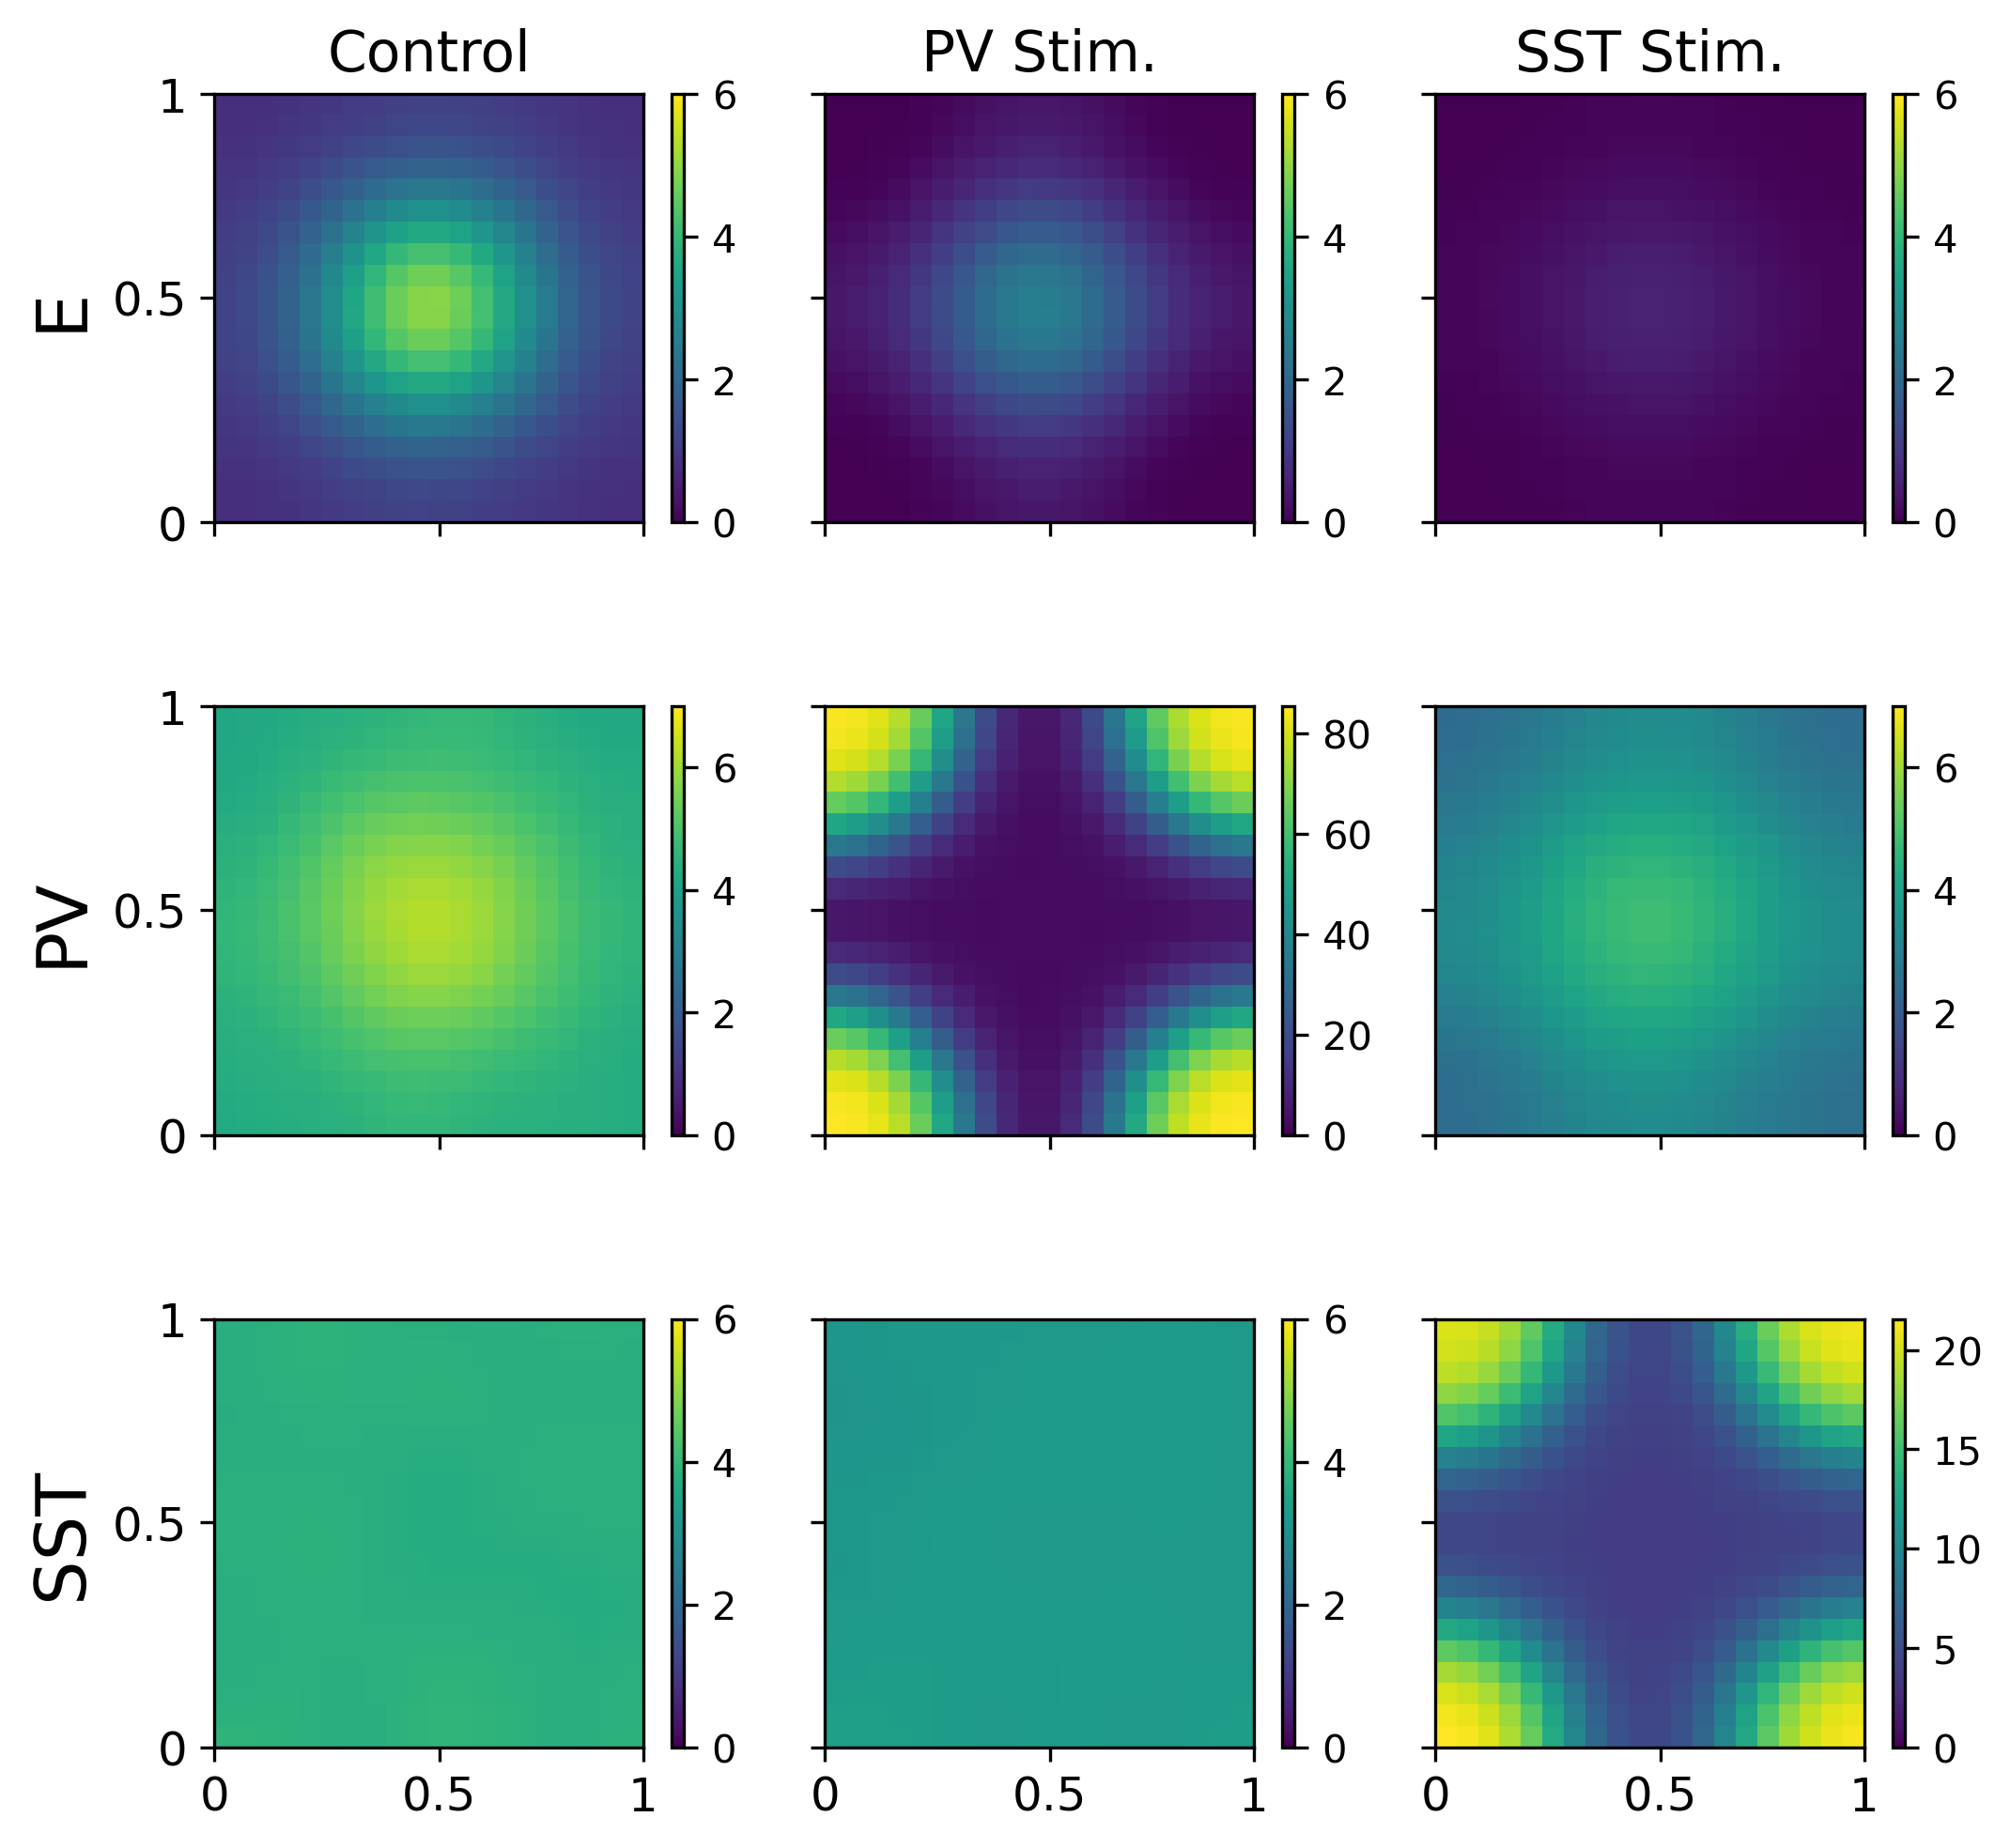

In [53]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

matplotlib.rcParams.update({'font.size': 12})
fig, axes = plt.subplots(3,3,figsize=(12,8), dpi=300)
vm = 40
for cond_i in range(3):
    ax = axes[0, cond_i]

    exc_smoothed = exc_smoothed_all[cond_i]
    im = ax.imshow(exc_smoothed, vmin=0, vmax=6)
    ax.set_xlim(-0.5,19.5)
    ax.set_ylim(-0.5,19.5)
    ax.set_xticks([-0.5,10,19.5])
    ax.set_yticks([-0.5,10,19.5])
    ax.set_xticklabels(['','',''])
    ax.set_yticklabels(['','',''])
    # ax.set_yticklabels([0,0.5,1])
    # ax.set_ylabel('Exc')
    if cond_i==0:
        ax.set_yticklabels([0,0.5,1])


    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='3%', pad=0.1)
    fig.subplots_adjust(left=0.2, right=0.7)
    cbar = fig.colorbar(im, cax=cax, orientation='vertical')
    cbar.ax.tick_params(labelsize=10)

    ax = axes[1, cond_i]

    pv_smoothed = pv_smoothed_all[cond_i]
    if cond_i in [0,2]:
        im = ax.imshow(pv_smoothed, vmin=0, vmax = 7)
    else:
        im = ax.imshow(pv_smoothed, vmin=0)
    ax.set_xlim(-0.5,19.5)
    ax.set_ylim(-0.5,19.5)
    ax.set_xticks([-0.5,10,19.5])
    ax.set_yticks([-0.5,10,19.5])
    ax.set_xticklabels(['','',''])
    ax.set_yticklabels(['','',''])
    # ax.set_yticklabels([0,0.5,1])
    # ax.set_ylabel('PV')
    if cond_i==0:
        ax.set_yticklabels([0,0.5,1])
        ax.set_ylabel('y-position (mm)')

    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='3%', pad=0.1)
    
    fig.subplots_adjust(left=0.2, right=0.7)
    cbar = fig.colorbar(im, cax=cax, orientation='vertical')
    cbar.ax.tick_params(labelsize=10)

    ax = axes[2, cond_i]
#     im = ax.imshow(sst_rates, vmin=0)#, vmax= vm)
    sst_smoothed = sst_smoothed_all[cond_i]
    if cond_i in [0,1]:
        im = ax.imshow(sst_smoothed, vmin=0, vmax=6)
    else:
        im = ax.imshow(sst_smoothed, vmin=0)
    ax.set_xlim(-0.5,19.5)
    ax.set_ylim(-0.5,19.5)
    ax.set_xticks([-0.5,10,19.5])
    ax.set_yticks([-0.5,10,19.5])
    ax.set_xticklabels(['','',''])
    ax.set_yticklabels(['','',''])
    ax.set_xticklabels([0,0.5,1])
    # ax.set_yticklabels([0,0.5,1])
    # ax.set_ylabel('SST')
    
    if cond_i==0:
        ax.set_yticklabels([0,0.5,1])
#     if cond_i ==1:
#         ax.set_xlabel('x-position (mm)')

    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='3%', pad=0.1)
    cbar = fig.colorbar(im, cax=cax, orientation='vertical')
    cbar.ax.tick_params(labelsize=10)

    fig.subplots_adjust(left=0.2, right=0.7, wspace=0.3)
    
axes[0,0].set_ylabel('E', fontsize=18)
axes[1,0].set_ylabel('PV', fontsize=18)
axes[2,0].set_ylabel('SST', fontsize=18)

axes[0,0].set_title('Control')
axes[0,1].set_title('PV Stim.')
axes[0,2].set_title('SST Stim.')



plt.subplots_adjust(left=0.2, right=0.7)
# plt.savefig('response_figs/RespFig4b.svg')
# plt.savefig('response_figs/RespFig4b_noscale.pdf')
plt.savefig('response2figs/FigRAB.svg')
# plt.show()

## Detailed distance-dependence

In [3]:
def get_rates_v_distance(all_spikes, all_positions, t_starts=[300, 1900, 3500], binsize=100):
    dx = 0.05
    distances = np.arange(0,0.8,dx)
    exc_count = np.zeros(len(distances), dtype=int)
    pv_count = np.zeros(len(distances), dtype=int)
    sst_count = np.zeros(len(distances), dtype=int)
    total_time = 0
    l_center = np.array([0,0])
    
    exc_n_count = np.zeros(len(distances))
    pv_n_count = np.zeros(len(distances))
    sst_n_count = np.zeros(len(distances))
    for ni in range(8000):
        pos = all_positions[ni,:]
        dist = periodic_distance(pos, l_center)
        d_index = int(dist/dx)
        exc_n_count[d_index] += 1
    for ni in range(8000,9000):
        pos = all_positions[ni,:]
        dist = periodic_distance(pos, l_center)
        d_index = int(dist/dx)
        pv_n_count[d_index] += 1
    for ni in range(9000,10000):
        pos = all_positions[ni,:]
        dist = periodic_distance(pos, l_center)
        d_index = int(dist/dx)
        sst_n_count[d_index] += 1
    
    for t_start in t_starts:
#         print(t_start, end=' ')
        t_stop = t_start + binsize
        total_time += binsize
        # Initialize empty lists to store positions of spiking neurons
        exc_positions = []
        pv_positions = []
        sst_positions = []

        # Iterate over neurons and their spike times
        for i, spikes in enumerate(all_spikes):
            # Check if the neuron spiked between t_start and t_stop
            spiking_times = spikes[(spikes >= t_start) & (spikes <= t_stop)]
            if len(spiking_times) > 0:
                # Append positions based on neuron type
                if i < 8000:
                    exc_positions.extend(all_positions[i, :].tolist() for _ in spiking_times)
                elif 8000 <= i < 9000:
                    pv_positions.extend(all_positions[i, :].tolist() for _ in spiking_times)
                else:
                    sst_positions.extend(all_positions[i, :].tolist() for _ in spiking_times)

        # Convert lists to numpy arrays for plotting
        exc_positions = np.array(exc_positions)
        pv_positions = np.array(pv_positions)
        sst_positions = np.array(sst_positions)

        # Iterate over each particle and count the number of particles in each patch
        for particle in exc_positions:
            dist = periodic_distance(particle, l_center)
            d_index = int(dist/dx)
            exc_count[d_index] += 1  # Increment the count for the corresponding patch
        # Iterate over each particle and count the number of particles in each patch
        for particle in pv_positions:
            dist = periodic_distance(particle, l_center)
            d_index = int(dist/dx)
            pv_count[d_index] += 1  # Increment the count for the corresponding patch
        # Iterate over each particle and count the number of particles in each patch
        for particle in sst_positions:
            dist = periodic_distance(particle, l_center)
            d_index = int(dist/dx)
            sst_count[d_index] += 1  # Increment the count for the corresponding patch

    total_time = total_time/1000
    return exc_count/exc_n_count/total_time, pv_count/pv_n_count/total_time, sst_count/sst_n_count/total_time

In [4]:
simname = 't90_a0.07_pf0.8'
cond = 'PV_0.33'
stim_times = [1100+1600*i for i in range(3)]
control_times = [300+1600*i for i in range(3)]

exc_all_rates_control, pv_all_rates_control, sst_all_rates_control = [], [], []
exc_all_rates_pv, pv_all_rates_pv, sst_all_rates_pv = [], [], []
exc_all_rates_sst, pv_all_rates_sst, sst_all_rates_sst = [], [], []

for seed in range(1,101):
    print(seed, end= ',')
    datadir='/storage/home/hcoda1/5/skim3438/p-hchoi387-0/CellTypeCircuit/newCode/data'
    with open(f'{datadir}/{simname}/results_{seed}/%s_spikes.pickle'%cond,'rb') as f:
        all_spikes = pickle.load(f)
    with open(f'{datadir}/{simname}/results_{seed}/%s_positions.pickle'%cond,'rb') as f:
        all_positions = pickle.load(f)
        
    exc_rate, pv_rate, sst_rate = get_rates_v_distance(all_spikes, all_positions, t_starts = control_times)
    
    exc_all_rates_control.append(exc_rate)
    pv_all_rates_control.append(pv_rate)
    sst_all_rates_control.append(sst_rate)
    
    exc_rate, pv_rate, sst_rate = get_rates_v_distance(all_spikes, all_positions, t_starts = stim_times)
    
    exc_all_rates_pv.append(exc_rate)
    pv_all_rates_pv.append(pv_rate)
    sst_all_rates_pv.append(sst_rate)
    
cond = 'SOM_0.33'
for seed in range(1,101):
    print(seed, end= ',')
    datadir='/storage/home/hcoda1/5/skim3438/p-hchoi387-0/CellTypeCircuit/newCode/data'
    with open(f'{datadir}/{simname}/results_{seed}/%s_spikes.pickle'%cond,'rb') as f:
        all_spikes = pickle.load(f)
    with open(f'{datadir}/{simname}/results_{seed}/%s_positions.pickle'%cond,'rb') as f:
        all_positions = pickle.load(f)
    
    exc_rate, pv_rate, sst_rate = get_rates_v_distance(all_spikes, all_positions, t_starts = stim_times)
    
    exc_all_rates_sst.append(exc_rate)
    pv_all_rates_sst.append(pv_rate)
    sst_all_rates_sst.append(sst_rate)

1,

/scratch/1412944/ipykernel_768275/837074763.py:73: RuntimeWarning: invalid value encountered in divide
  return exc_count/exc_n_count/total_time, pv_count/pv_n_count/total_time, sst_count/sst_n_count/total_time


2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,

In [5]:
exc_all_rates = np.array(exc_all_rates_control)
pv_all_rates = np.array(pv_all_rates_control)
sst_all_rates = np.array(sst_all_rates_control)
exc_rates_control = np.mean(exc_all_rates, axis=0)
pv_rates_control = np.mean(pv_all_rates, axis=0)
sst_rates_control = np.mean(sst_all_rates, axis=0)

exc_all_rates = np.array(exc_all_rates_pv)
pv_all_rates = np.array(pv_all_rates_pv)
sst_all_rates = np.array(sst_all_rates_pv)
exc_rates_pv = np.mean(exc_all_rates, axis=0)
pv_rates_pv = np.mean(pv_all_rates, axis=0)
sst_rates_pv = np.mean(sst_all_rates, axis=0)

exc_all_rates = np.array(exc_all_rates_sst)
pv_all_rates = np.array(pv_all_rates_sst)
sst_all_rates = np.array(sst_all_rates_sst)
exc_rates_sst = np.mean(exc_all_rates, axis=0)
pv_rates_sst = np.mean(pv_all_rates, axis=0)
sst_rates_sst = np.mean(sst_all_rates, axis=0)

/scratch/1412944/ipykernel_768275/1212967263.py:8: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  axes[0].scatter(x+0.05/2,pv_rates_pv, c=pvcolor)
/scratch/1412944/ipykernel_768275/1212967263.py:10: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  axes[1].scatter(x+0.05/2,sst_rates_sst, c=sstcolor)


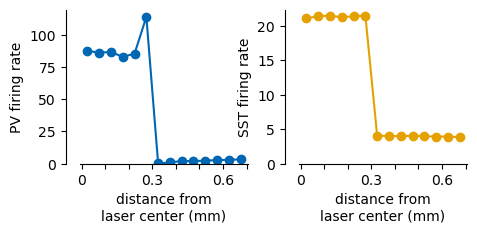

In [27]:
matplotlib.rcParams.update({'font.size': 10})

fig, axes = plt.subplots(1,2, figsize=(5,2))
plt.rcParams['svg.fonttype'] = 'none'

x = np.arange(0,0.8,0.05)
axes[0].plot(x+0.05/2,pv_rates_pv, c=pvcolor)
axes[0].scatter(x+0.05/2,pv_rates_pv, c=pvcolor)
axes[1].plot(x+0.05/2,sst_rates_sst, c=sstcolor)
axes[1].scatter(x+0.05/2,sst_rates_sst, c=sstcolor)


plt.subplots_adjust(wspace=0.3)

for ax in axes:
    ax.set_xticks([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7])
    ax.set_xticklabels([0,'','',0.3,'','',0.6,''])
    ax.set_xlabel('distance from\nlaser center (mm)')
    ax.set_ylim(0,)
    
    # Remove right and top spines
#     ax = plt.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    # Add slight separation between bottom and left spines
    ax.spines['left'].set_position(('outward', 10))
#     ax.spines['bottom'].set_position(('outward', 10))
    
axes[0].set_ylabel('PV firing rate')
axes[1].set_ylabel('SST firing rate')

# plt.show()
plt.savefig('response2figs/laser_response.svg')

In [56]:
pv_rates_pv

array([           nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
       8.65753054e+01,            nan,            nan, 8.53797412e+01,
       8.71544084e+01, 8.80165483e+01,            nan, 8.74577087e+01,
       8.61736526e+01, 8.33725100e+01, 8.05197611e+01, 7.96533166e+01,
       7.77271470e+01, 7.99713968e+01, 8.40676825e+01, 8.93776877e+01,
       9.49229264e+01, 1.01888516e+02, 1.07987194e+02, 1.15314248e+02,
       1.19929215e+02, 1.24474067e+02, 0.00000000e+00, 1.13659926e-02,
       1.54675417e-02, 3.26390292e-02, 7.39320598e-02, 1.95607475e-01,
       3.84682617e-01, 7.95456765e-01, 1.17332502e+00, 1.73313343e+00,
       1.91487738e+00, 1.84918801e+00, 1.94601610e+00, 1.94841560e+00,
       1.97845994e+00, 2.01075572e+00, 1.85953747e+00, 1.87529752e+00,
       1.91050673e+00, 2.06587028e+00, 2.03490916e+00, 2.07404514e+00,
       2.20389055e+00, 2.33307675e+00, 2.49765876e+00, 2.45683949e+00,
      

## With E->SST distance dependence

In [45]:
simname = 'pe06_es'
# simname = 't90_a0.07_pf0.8'
cond = 'PV_0.33'
stim_times = [1100+1600*i for i in range(3)]
control_times = [300+1600*i for i in range(3)]

exc_all_rates_control, pv_all_rates_control, sst_all_rates_control = [], [], []
exc_all_rates_pv, pv_all_rates_pv, sst_all_rates_pv = [], [], []
exc_all_rates_sst, pv_all_rates_sst, sst_all_rates_sst = [], [], []

for seed in range(1,31):
    print(seed, end= ',')
    datadir='/storage/home/hcoda1/5/skim3438/p-hchoi387-0/CellTypeCircuit/newCode/data'
    with open(f'{datadir}/{simname}/results_{seed}/%s_spikes.pickle'%cond,'rb') as f:
        all_spikes = pickle.load(f)
    with open(f'{datadir}/{simname}/results_{seed}/%s_positions.pickle'%cond,'rb') as f:
        all_positions = pickle.load(f)
        
    exc_rate, pv_rate, sst_rate = get_rates(all_spikes, all_positions, t_starts = control_times)
    
    exc_all_rates_control.append(exc_rate)
    pv_all_rates_control.append(pv_rate)
    sst_all_rates_control.append(sst_rate)
    
    exc_rate, pv_rate, sst_rate = get_rates(all_spikes, all_positions, t_starts = stim_times)
    
    exc_all_rates_pv.append(exc_rate)
    pv_all_rates_pv.append(pv_rate)
    sst_all_rates_pv.append(sst_rate)
    
cond = 'SST_0.33'
for seed in range(1,31):
    print(seed, end= ',')
    datadir='/storage/home/hcoda1/5/skim3438/p-hchoi387-0/CellTypeCircuit/newCode/data'
    with open(f'{datadir}/{simname}/results_{seed}/%s_spikes.pickle'%cond,'rb') as f:
        all_spikes = pickle.load(f)
    with open(f'{datadir}/{simname}/results_{seed}/%s_positions.pickle'%cond,'rb') as f:
        all_positions = pickle.load(f)
    
    exc_rate, pv_rate, sst_rate = get_rates(all_spikes, all_positions, t_starts = stim_times)
    
    exc_all_rates_sst.append(exc_rate)
    pv_all_rates_sst.append(pv_rate)
    sst_all_rates_sst.append(sst_rate)
    
exc_all_rates = np.array(exc_all_rates_control)
pv_all_rates = np.array(pv_all_rates_control)
sst_all_rates = np.array(sst_all_rates_control)
exc_rates_control = np.mean(exc_all_rates, axis=0)
pv_rates_control = np.mean(pv_all_rates, axis=0)
sst_rates_control = np.mean(sst_all_rates, axis=0)

exc_all_rates = np.array(exc_all_rates_pv)
pv_all_rates = np.array(pv_all_rates_pv)
sst_all_rates = np.array(sst_all_rates_pv)
exc_rates_pv = np.mean(exc_all_rates, axis=0)
pv_rates_pv = np.mean(pv_all_rates, axis=0)
sst_rates_pv = np.mean(sst_all_rates, axis=0)

exc_all_rates = np.array(exc_all_rates_sst)
pv_all_rates = np.array(pv_all_rates_sst)
sst_all_rates = np.array(sst_all_rates_sst)
exc_rates_sst = np.mean(exc_all_rates, axis=0)
pv_rates_sst = np.mean(pv_all_rates, axis=0)
sst_rates_sst = np.mean(sst_all_rates, axis=0)

1,300 1900 3500 1100 2700 4300 2,300 1900 3500 1100 2700 4300 3,300 1900 3500 1100 2700 4300 4,300 1900 3500 1100 2700 4300 5,300 1900 3500 1100 2700 4300 6,300 1900 3500 1100 2700 4300 7,300 1900 3500 1100 2700 4300 8,300 1900 3500 1100 2700 4300 9,300 1900 3500 1100 2700 4300 10,300 1900 3500 1100 2700 4300 11,300 1900 3500 1100 2700 4300 12,300 1900 3500 1100 2700 4300 13,300 1900 3500 1100 2700 4300 14,300 1900 3500 1100 2700 4300 15,300 1900 3500 1100 2700 4300 16,300 1900 3500 1100 2700 4300 17,300 1900 3500 1100 2700 4300 18,300 1900 3500 1100 2700 4300 19,300 1900 3500 1100 2700 4300 20,300 1900 3500 1100 2700 4300 21,300 1900 3500 1100 2700 4300 22,300 1900 3500 1100 2700 4300 23,300 1900 3500 1100 2700 4300 24,300 1900 3500 1100 2700 4300 25,300 1900 3500 1100 2700 4300 26,300 1900 3500 1100 2700 4300 27,300 1900 3500 1100 2700 4300 28,300 1900 3500 1100 2700 4300 29,300 1900 3500 1100 2700 4300 30,300 1900 3500 1100 2700 4300 1,1100 2700 4300 2,1100 2700 4300 3,1100 2700 430

In [46]:
from scipy.ndimage import gaussian_filter

smooth = True

if smooth == True:
    exc_smoothed_control = gaussian_filter(exc_rates_control, sigma=2)
    pv_smoothed_control = gaussian_filter(pv_rates_control, sigma=2)
    sst_smoothed_control = gaussian_filter(sst_rates_control, sigma=2)

    exc_smoothed_pv = gaussian_filter(exc_rates_pv, sigma=2)
    pv_smoothed_pv = gaussian_filter(pv_rates_pv, sigma=2)
    sst_smoothed_pv = gaussian_filter(sst_rates_pv, sigma=2)

    exc_smoothed_sst = gaussian_filter(exc_rates_sst, sigma=2)
    pv_smoothed_sst = gaussian_filter(pv_rates_sst, sigma=2)
    sst_smoothed_sst = gaussian_filter(sst_rates_sst, sigma=2)

    exc_smoothed_all = [exc_smoothed_control, exc_smoothed_pv, exc_smoothed_sst]
    pv_smoothed_all  = [pv_smoothed_control,  pv_smoothed_pv,  pv_smoothed_sst]
    sst_smoothed_all = [sst_smoothed_control, sst_smoothed_pv, sst_smoothed_sst]

else:
    exc_smoothed_all = [exc_rates_control, exc_rates_pv, exc_rates_sst]
    pv_smoothed_all  = [pv_rates_control,  pv_rates_pv,  pv_rates_sst]
    sst_smoothed_all = [sst_rates_control, sst_rates_pv, sst_rates_sst]

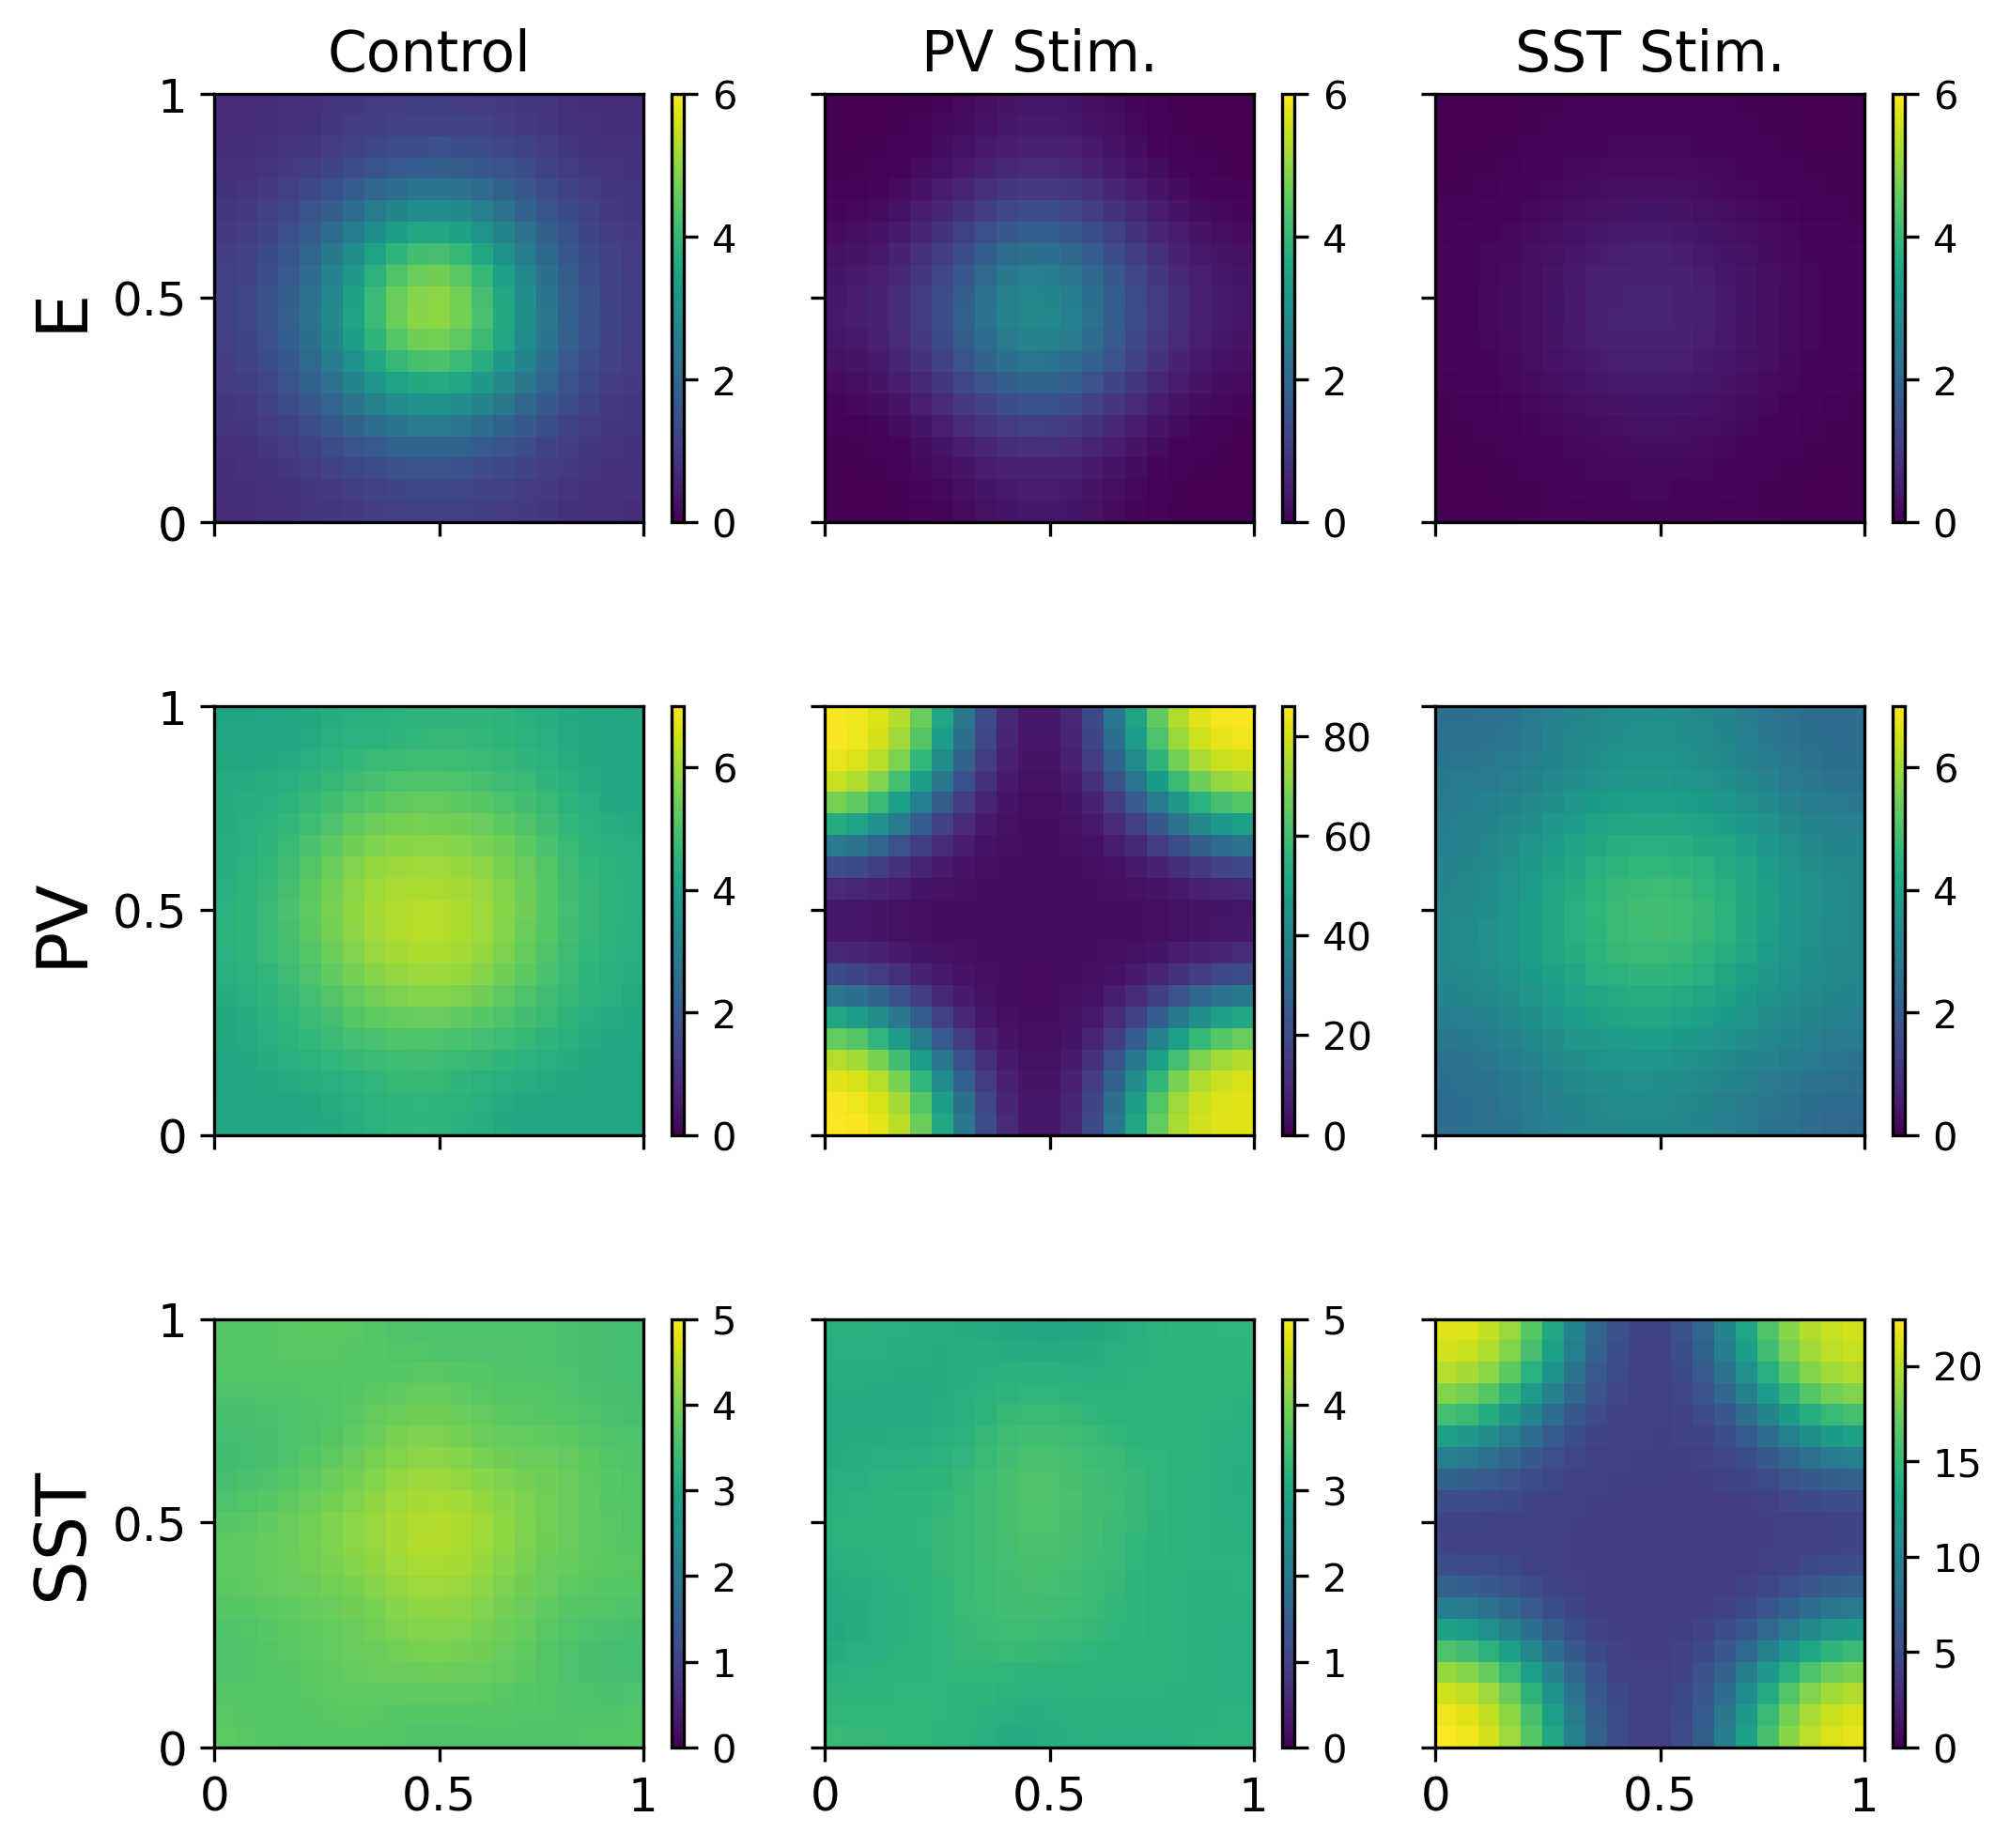

In [47]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

matplotlib.rcParams.update({'font.size': 12})
fig, axes = plt.subplots(3,3,figsize=(12,8), dpi=300)
vm = 40
for cond_i in range(3):
    ax = axes[0, cond_i]

    exc_smoothed = exc_smoothed_all[cond_i]
    im = ax.imshow(exc_smoothed, vmin=0, vmax=6)
    ax.set_xlim(-0.5,19.5)
    ax.set_ylim(-0.5,19.5)
    ax.set_xticks([-0.5,10,19.5])
    ax.set_yticks([-0.5,10,19.5])
    ax.set_xticklabels(['','',''])
    ax.set_yticklabels(['','',''])
    # ax.set_yticklabels([0,0.5,1])
    # ax.set_ylabel('Exc')
    if cond_i==0:
        ax.set_yticklabels([0,0.5,1])


    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='3%', pad=0.1)
    fig.subplots_adjust(left=0.2, right=0.7)
    cbar = fig.colorbar(im, cax=cax, orientation='vertical')
    cbar.ax.tick_params(labelsize=10)

    ax = axes[1, cond_i]

    pv_smoothed = pv_smoothed_all[cond_i]
    if cond_i in [0,2]:
        im = ax.imshow(pv_smoothed, vmin=0, vmax = 7)
    else:
        im = ax.imshow(pv_smoothed, vmin=0)
    ax.set_xlim(-0.5,19.5)
    ax.set_ylim(-0.5,19.5)
    ax.set_xticks([-0.5,10,19.5])
    ax.set_yticks([-0.5,10,19.5])
    ax.set_xticklabels(['','',''])
    ax.set_yticklabels(['','',''])
    # ax.set_yticklabels([0,0.5,1])
    # ax.set_ylabel('PV')
    if cond_i==0:
        ax.set_yticklabels([0,0.5,1])
        ax.set_ylabel('y-position (mm)')

    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='3%', pad=0.1)
    
    fig.subplots_adjust(left=0.2, right=0.7)
    cbar = fig.colorbar(im, cax=cax, orientation='vertical')
    cbar.ax.tick_params(labelsize=10)

    ax = axes[2, cond_i]
#     im = ax.imshow(sst_rates, vmin=0)#, vmax= vm)
    sst_smoothed = sst_smoothed_all[cond_i]
    if cond_i in [1]:
        im = ax.imshow(sst_smoothed, vmin=0, vmax=5)
    elif cond_i == 0:
        im = ax.imshow(sst_smoothed, vmin=0, vmax=5)
    else:
        im = ax.imshow(sst_smoothed, vmin=0)
    ax.set_xlim(-0.5,19.5)
    ax.set_ylim(-0.5,19.5)
    ax.set_xticks([-0.5,10,19.5])
    ax.set_yticks([-0.5,10,19.5])
    ax.set_xticklabels(['','',''])
    ax.set_yticklabels(['','',''])
    ax.set_xticklabels([0,0.5,1])
    # ax.set_yticklabels([0,0.5,1])
    # ax.set_ylabel('SST')
    
    if cond_i==0:
        ax.set_yticklabels([0,0.5,1])
#     if cond_i ==1:
#         ax.set_xlabel('x-position (mm)')

    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='3%', pad=0.1)
    cbar = fig.colorbar(im, cax=cax, orientation='vertical')
    cbar.ax.tick_params(labelsize=10)

    fig.subplots_adjust(left=0.2, right=0.7, wspace=0.3)
    
axes[0,0].set_ylabel('E', fontsize=18)
axes[1,0].set_ylabel('PV', fontsize=18)
axes[2,0].set_ylabel('SST', fontsize=18)

axes[0,0].set_title('Control')
axes[0,1].set_title('PV Stim.')
axes[0,2].set_title('SST Stim.')



plt.subplots_adjust(left=0.2, right=0.7)
# plt.savefig('response_figs/RespFig4b.svg')
# plt.savefig('response_figs/RespFig4b_noscale.pdf')
plt.savefig('response2figs/FigRCB.svg')
# plt.show()

In [14]:
exc_rates_control

array([[0.72222222, 0.77777778, 0.84444444, 0.95      , 0.96666667,
        0.85555556, 1.07777778, 1.05555556, 1.06111111, 1.17777778,
        1.08888889, 1.11111111, 0.82222222, 0.98333333, 0.97222222,
        0.91111111, 0.82777778, 0.92222222, 0.67222222, 0.67777778],
       [0.75      , 0.71111111, 0.96666667, 0.89444444, 0.87222222,
        0.94444444, 0.98333333, 1.06111111, 1.12222222, 1.11111111,
        1.01666667, 1.23888889, 1.04444444, 0.91666667, 1.1       ,
        0.91111111, 0.87222222, 0.79444444, 0.83333333, 0.95      ],
       [0.73333333, 0.85      , 0.77777778, 0.95      , 0.91111111,
        0.98333333, 0.96666667, 1.28333333, 1.17777778, 1.19444444,
        1.37777778, 1.16111111, 0.95555556, 1.38333333, 1.03888889,
        1.03333333, 0.83888889, 0.85      , 0.69444444, 0.66666667],
       [0.85555556, 0.69444444, 0.86666667, 0.97222222, 0.9       ,
        1.15      , 1.39444444, 1.42777778, 1.24444444, 1.38888889,
        1.66111111, 1.51111111, 1.37222222, 1

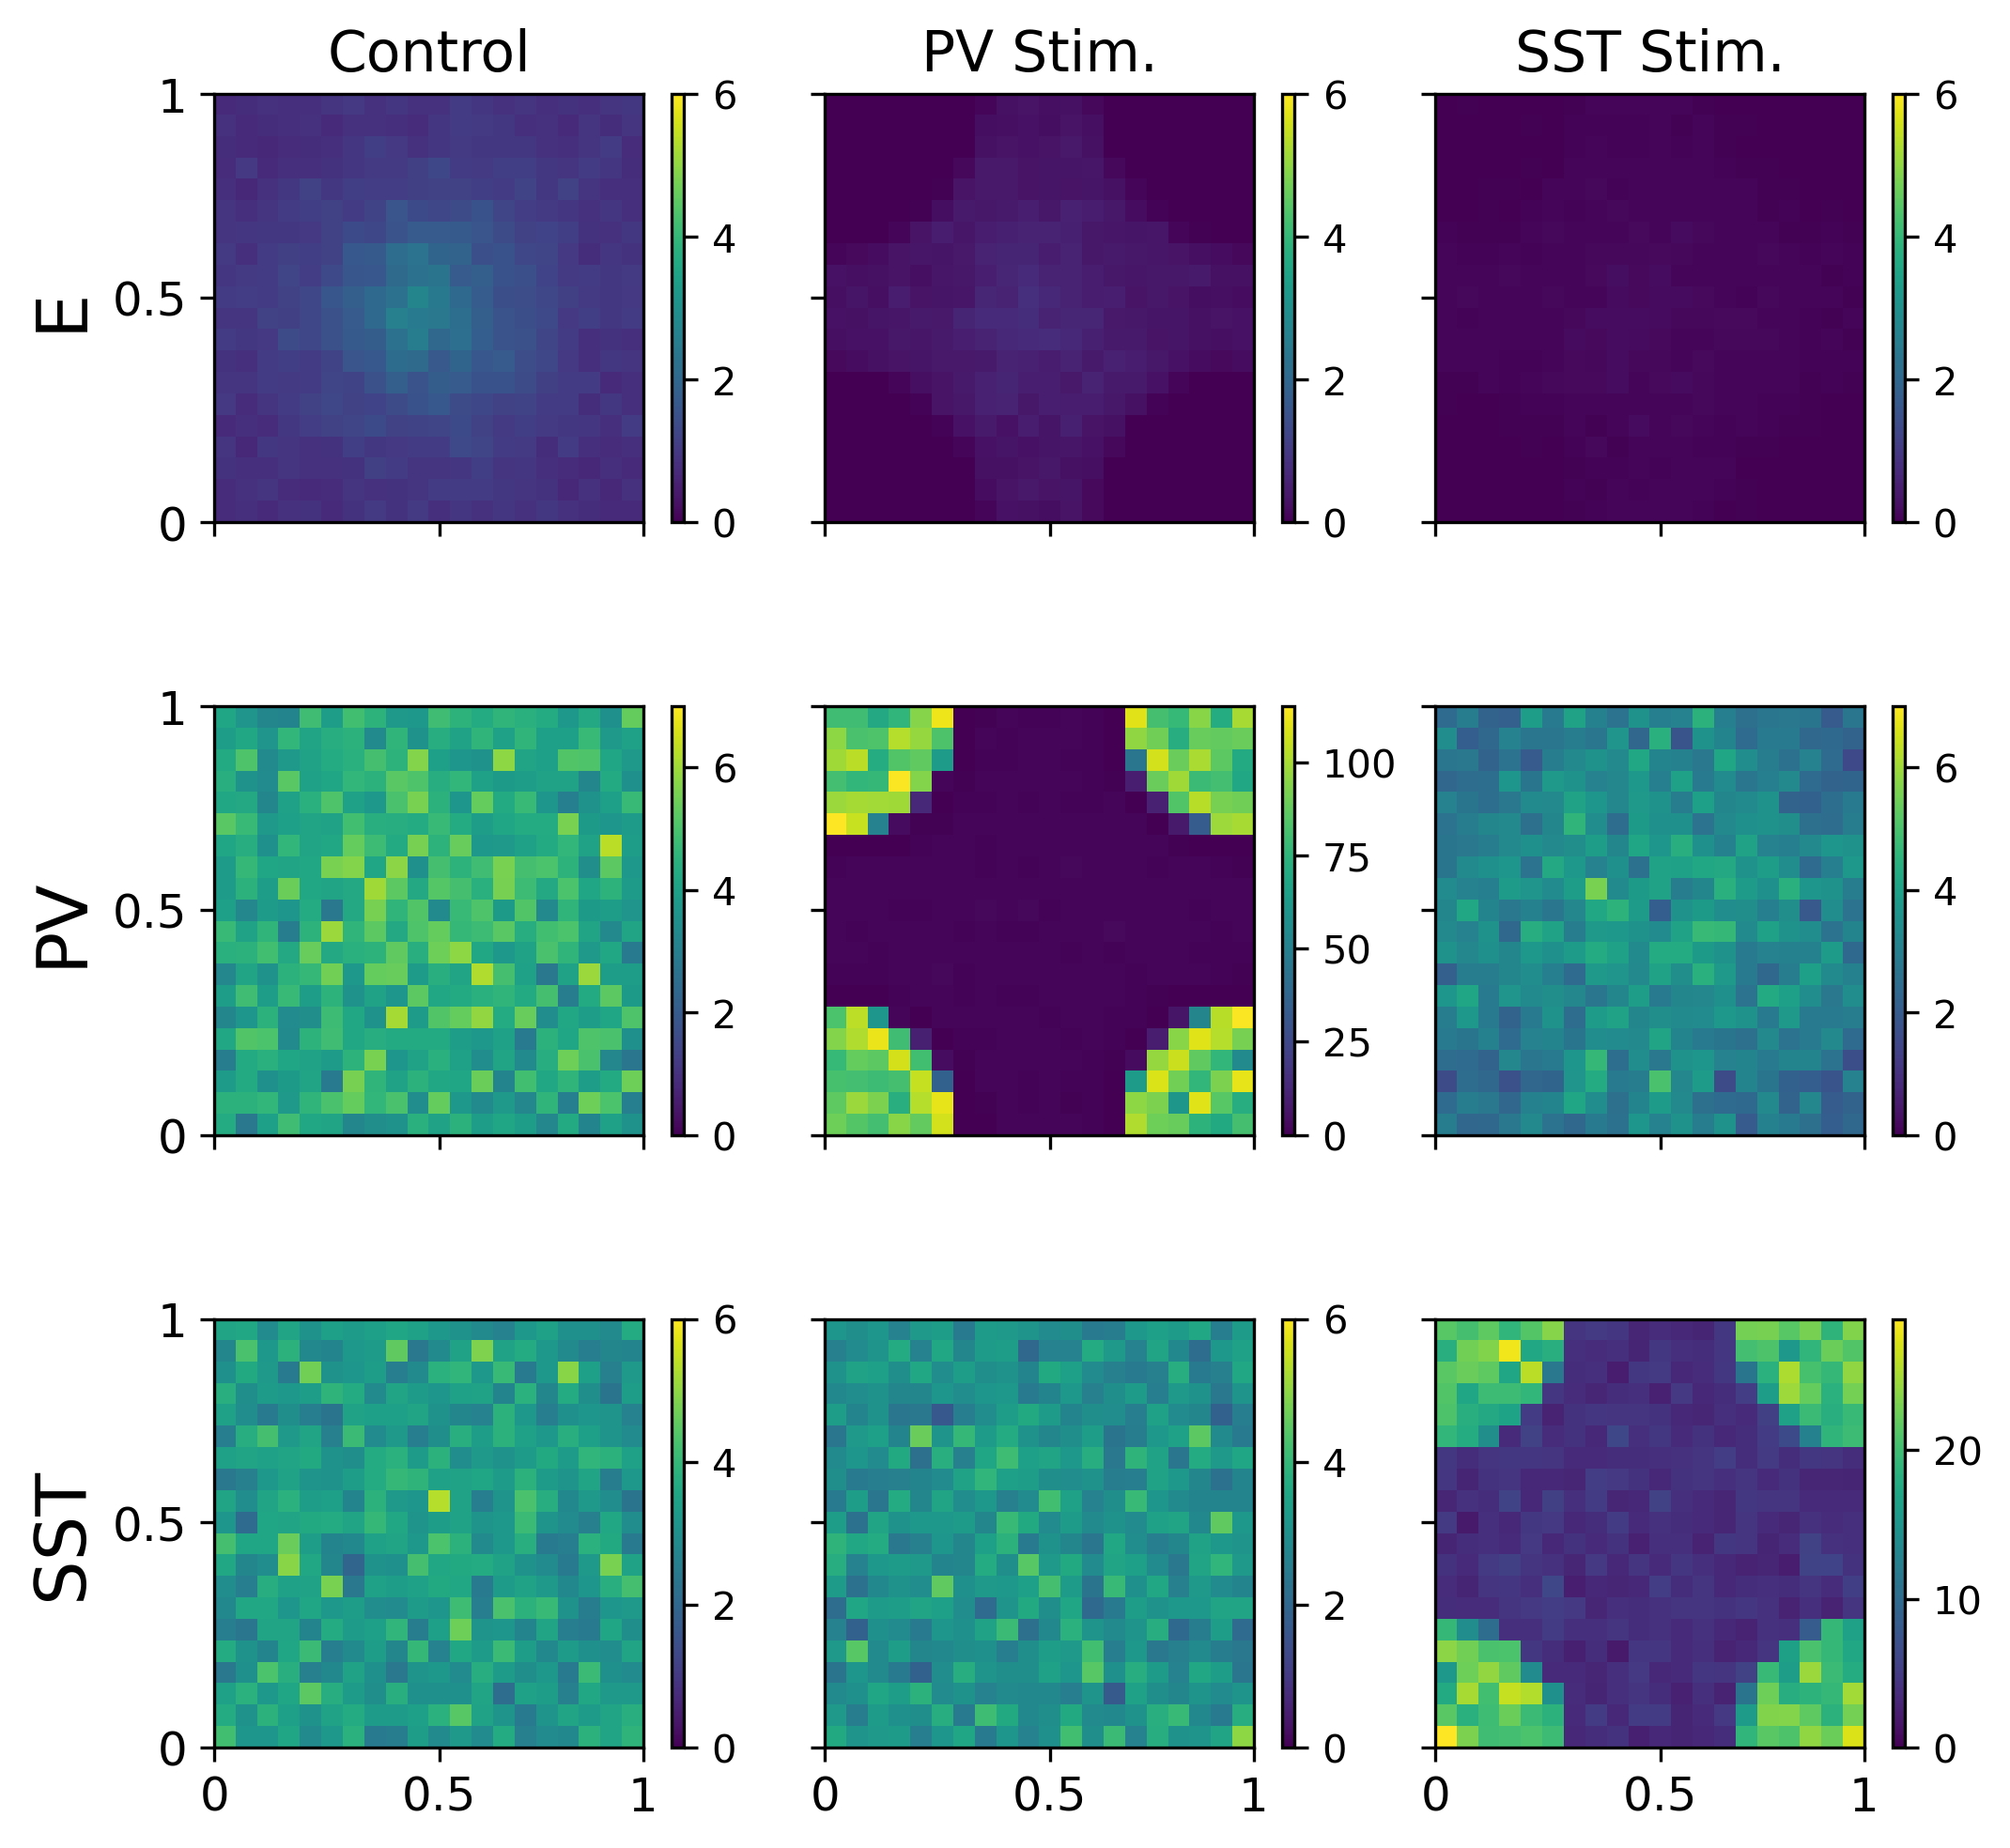

In [131]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

matplotlib.rcParams.update({'font.size': 12})
fig, axes = plt.subplots(3,3,figsize=(12,8), dpi=300)
vm = 40
for cond_i in range(3):
    ax = axes[0, cond_i]

    exc_smoothed = exc_smoothed_all[cond_i]
    im = ax.imshow(exc_smoothed, vmin=0, vmax=6)
    ax.set_xlim(-0.5,19.5)
    ax.set_ylim(-0.5,19.5)
    ax.set_xticks([-0.5,10,19.5])
    ax.set_yticks([-0.5,10,19.5])
    ax.set_xticklabels(['','',''])
    ax.set_yticklabels(['','',''])
    # ax.set_yticklabels([0,0.5,1])
    # ax.set_ylabel('Exc')
    if cond_i==0:
        ax.set_yticklabels([0,0.5,1])


    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='3%', pad=0.1)
    fig.subplots_adjust(left=0.2, right=0.7)
    cbar = fig.colorbar(im, cax=cax, orientation='vertical')
    cbar.ax.tick_params(labelsize=10)

    ax = axes[1, cond_i]

    pv_smoothed = pv_smoothed_all[cond_i]
    if cond_i in [0,2]:
        im = ax.imshow(pv_smoothed, vmin=0, vmax = 7)
    else:
        im = ax.imshow(pv_smoothed, vmin=0)
    ax.set_xlim(-0.5,19.5)
    ax.set_ylim(-0.5,19.5)
    ax.set_xticks([-0.5,10,19.5])
    ax.set_yticks([-0.5,10,19.5])
    ax.set_xticklabels(['','',''])
    ax.set_yticklabels(['','',''])
    # ax.set_yticklabels([0,0.5,1])
    # ax.set_ylabel('PV')
    if cond_i==0:
        ax.set_yticklabels([0,0.5,1])
        ax.set_ylabel('y-position (mm)')

    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='3%', pad=0.1)
    
    fig.subplots_adjust(left=0.2, right=0.7)
    cbar = fig.colorbar(im, cax=cax, orientation='vertical')
    cbar.ax.tick_params(labelsize=10)

    ax = axes[2, cond_i]
#     im = ax.imshow(sst_rates, vmin=0)#, vmax= vm)
    sst_smoothed = sst_smoothed_all[cond_i]
    if cond_i in [0,1]:
        im = ax.imshow(sst_smoothed, vmin=0, vmax=6)
    else:
        im = ax.imshow(sst_smoothed, vmin=0)
    ax.set_xlim(-0.5,19.5)
    ax.set_ylim(-0.5,19.5)
    ax.set_xticks([-0.5,10,19.5])
    ax.set_yticks([-0.5,10,19.5])
    ax.set_xticklabels(['','',''])
    ax.set_yticklabels(['','',''])
    ax.set_xticklabels([0,0.5,1])
    # ax.set_yticklabels([0,0.5,1])
    # ax.set_ylabel('SST')
    
    if cond_i==0:
        ax.set_yticklabels([0,0.5,1])
#     if cond_i ==1:
#         ax.set_xlabel('x-position (mm)')

    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='3%', pad=0.1)
    cbar = fig.colorbar(im, cax=cax, orientation='vertical')
    cbar.ax.tick_params(labelsize=10)

    fig.subplots_adjust(left=0.2, right=0.7, wspace=0.3)
    
axes[0,0].set_ylabel('E', fontsize=18)
axes[1,0].set_ylabel('PV', fontsize=18)
axes[2,0].set_ylabel('SST', fontsize=18)

axes[0,0].set_title('Control')
axes[0,1].set_title('PV Stim.')
axes[0,2].set_title('SST Stim.')



plt.subplots_adjust(left=0.2, right=0.7)
# plt.savefig('response_figs/RespFig4b.svg')
# plt.savefig('response_figs/RespFig4b_noscale.pdf')
plt.show()